In [71]:
import os
import zipfile
import random
import tensorflow as tf
import shutil
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd
from matplotlib import pyplot

#!pip install -q -U keras-tuner
import keras_tuner as kt


In [72]:
#!zip "/content/images.zip" "/content/images"

In [73]:
print(getcwd())
path_arab_words = f"{getcwd()}/../AHDB.zip"
shutil.rmtree('/tmp')


local_zip = path_arab_words
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()



/content


In [74]:
try:
   
    base_dir = "/tmp/AHDB"

    train_dir = os.path.join(base_dir, 'training')
    validation_dir = os.path.join(base_dir, 'validation')
    testing_dir = os.path.join(base_dir, 'testing')
    
    s=['AAN','ABD','ALA','ALADHI','ALAM','ALLAH','ALLATI','ALYAWM','AN','AW','FI'
    ,'HADHA','HADHIHI','HIA','HOUNAKA','HOWA','ILA','KABLA','KAD','KAMA'
    ,'KANA','KHILALA','MA','MAA','MAN','MOHAMED','TOMA','YAKON']


    # a loop that creates a validation and a training dir for each classe
    # ex train_aan_dir = os.path.join(train_dir, 'AAN')
    for k in s:

      exec(f'train_{k}_dir = os.path.join(train_dir, k)')
      exec(f'validation_{k}_dir = os.path.join(validation_dir, k)')
      exec(f'test_{k}_dir = os.path.join(testing_dir, k)')
      valid = '/tmp/recognize/validation/'+k+'/'
      train ='/tmp/recognize/training/'+k+'/'
      test ='/tmp/recognize/testing/'+k+'/'
      os.makedirs(test)
      os.makedirs(train)
      os.makedirs(valid)
     


except OSError:
    pass

In [75]:
def split_data(SOURCE, TRAINING,VALIDATION, TESTING, TRAIN_SIZE, VAL_SIZE):

    listdir= os.listdir (SOURCE)
    list_source= random.sample(listdir,len(listdir))
    for i in range (len (list_source)):
        file_source = os.path.join(SOURCE,list_source[i-1])
        file_trainin = os.path.join(TRAINING,list_source[i-1])
        file_valid = os.path.join(VALIDATION,list_source[i-1])
        file_tastin = os.path.join(TESTING,list_source[i-1])
        if (i<len (list_source)*TRAIN_SIZE):
            if (os.path.getsize(file_source))!=0:
                #copy it
                copyfile(file_source,file_trainin)
        elif i>= len (list_source)*TRAIN_SIZE and i <len (list_source)*VAL_SIZE :
             if (os.path.getsize(file_source))!=0:
                #copy it
                copyfile(file_source,file_valid)
        else :
          if (os.path.getsize(file_source))!=0:
                #copy it
                copyfile(file_source,file_tastin)


train_size = .70  # % training and the others for test 
valid_size = .85   
    
    
for k in s:
      source_dir="/tmp/AHDB/"+k+"/"
      testing_dir = '/tmp/recognize/testing/'+k+'/'
      train_dir ='/tmp/recognize/training/'+k+'/'
      validation_dir ='/tmp/recognize/validation/'+k+'/'
      split_data(source_dir, train_dir,validation_dir, testing_dir, train_size,valid_size)


In [76]:
from tensorflow.python.keras.backend import dropout
from tensorflow.python import keras
# DEFINE A KERAS MODEL TO CLASSIFY THE 28 CLASSES
# USING 3 CONVOLUTION LAYERS


#_______________tweeking parameters____________
# Tune the number of units in the first Dense layer
# Choose an optimal value between 32-512

def model_builder(hp):
    
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hp_dropout = hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)
  hp_activation=hp.Choice('activation',values=["relu","elu"])
  model = tf.keras.models.Sequential([

      # Note the input shape is the desired size of the image 150x150 with 3 bytes color
      tf.keras.layers.Conv2D(16, (3,3), activation=hp_activation, input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(32, (3,3), activation=hp_activation),
      tf.keras.layers.MaxPooling2D(2,2), 
      tf.keras.layers.Conv2D(64, (3,3), activation=hp_activation), 
      tf.keras.layers.MaxPooling2D(2,2),
      tf.keras.layers.Conv2D(128, (3,3), activation=hp_activation), 
      tf.keras.layers.MaxPooling2D(2,2),
      # Flatten the results to feed into a DNN
      tf.keras.layers.Flatten(), 
      #  hidden layer
      tf.keras.layers.Dense(hp_units, activation=hp_activation), 
      # Add a dropout rate of 0.2...
      tf.keras.layers.Dropout(hp_dropout),
      # Only 1 output neuron. It will contain a value from 0 or 1 where 1 in the indice of the predicted class
      tf.keras.layers.Dense(28, activation='softmax') 
  ])

  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=RMSprop(lr=hp_learning_rate), loss='categorical_crossentropy', metrics=['acc'])

  return model



 

In [77]:
TRAINING_DIR = '/tmp/recognize/training/'



VALIDATION_DIR ='/tmp/recognize/validation/' 
validation_datagen = ImageDataGenerator( rescale = 1.0/255. )
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=10,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))



TESTING_DIR ='/tmp/recognize/testing/' 
testing_datagen = ImageDataGenerator( rescale = 1.0/255. )
testing_generator = validation_datagen.flow_from_directory(TESTING_DIR,
                                                         batch_size=10,
                                                         class_mode  = 'categorical',
                                                         target_size = (150, 150))
                       


training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      #shear_range=0.2,
      zoom_range=0.2,
      featurewise_center=True,
      featurewise_std_normalization=True,
      zca_whitening=True,
      #horizontal_flip=True,
      brightness_range=[0.4,1.5],
      fill_mode='nearest')

#os.makedirs('images')
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=10,
  #save_to_dir='images',
  #save_prefix='aug',
   #save_format='png'
)

Found 139 images belonging to 28 classes.
Found 136 images belonging to 28 classes.
Found 681 images belonging to 28 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:342: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


In [78]:
tuner = kt.Hyperband(model_builder,
                     objective='val_acc',
                     max_epochs=15,
                     factor=3,
                     overwrite=True
                     #directory='my_dir',
                     #project_name='intro_to_kt'
                     )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

tuner.search(train_generator, epochs=50,validation_data=validation_generator, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}, the optimal activation func is {best_hps.get('activation')}, 
the optimal dropout value is {best_hps.get('dropout')}.
""")
''' 
history = model.fit_generator(train_generator,
                              epochs=10,
                              verbose=1,
                              validation_data=validation_generator) '''


Trial 30 Complete [00h 01m 28s]
val_acc: 0.7194244861602783

Best val_acc So Far: 0.7194244861602783
Total elapsed time: 00h 17m 12s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 384 and the optimal learning rate for the optimizer
is 0.001, the optimal activation func is relu, 
the optimal dropout value is 0.30000000000000004.



' \nhistory = model.fit_generator(train_generator,\n                              epochs=10,\n                              verbose=1,\n                              validation_data=validation_generator) '

In [79]:
print('Best activation func: %s' %(best_hps.get('activation'),))
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.99):
      print("\nReached 97% val accuracy so cancelling training!")
      self.model.stop_training = True

model = tuner.hypermodel.build(best_hps)

callbacks = myCallback()
history = model.fit(train_generator, epochs=200,validation_data=validation_generator)

val_acc_per_epoch = history.history['val_acc']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Best activation func: relu
Epoch 1/200


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


69/69 [==============================] - 7s 85ms/step - loss: 3.3644 - acc: 0.0250 - val_loss: 3.3326 - val_acc: 0.0360
Epoch 2/200
69/69 [==============================] - 6s 81ms/step - loss: 3.3369 - acc: 0.0162 - val_loss: 3.3310 - val_acc: 0.0576
Epoch 3/200
69/69 [==============================] - 6s 82ms/step - loss: 3.3222 - acc: 0.0499 - val_loss: 3.1963 - val_acc: 0.0576
Epoch 4/200
69/69 [==============================] - 6s 81ms/step - loss: 3.2700 - acc: 0.0646 - val_loss: 3.1787 - val_acc: 0.1367
Epoch 5/200
69/69 [==============================] - 6s 83ms/step - loss: 3.2352 - acc: 0.0749 - val_loss: 2.9572 - val_acc: 0.1727
Epoch 6/200
69/69 [==============================] - 6s 83ms/step - loss: 3.1778 - acc: 0.0925 - val_loss: 2.8275 - val_acc: 0.1655
Epoch 7/200
69/69 [==============================] - 6s 83ms/step - loss: 3.0430 - acc: 0.1072 - val_loss: 2.3923 - val_acc: 0.2374
Epoch 8/200
69/69 [==============================] - 6s 82ms/step - loss: 2.9667 - acc: 

In [80]:

model = tuner.hypermodel.build(best_hps)

# Retrain the model
model=model.fit(train_generator, epochs=best_hps,validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/200
69/69 [==============================] - 7s 86ms/step - loss: 3.3902 - acc: 0.0294 - val_loss: 3.3274 - val_acc: 0.0432
Epoch 2/200
69/69 [==============================] - 6s 83ms/step - loss: 3.3399 - acc: 0.0396 - val_loss: 3.2901 - val_acc: 0.1151
Epoch 3/200
69/69 [==============================] - 6s 84ms/step - loss: 3.3046 - acc: 0.0573 - val_loss: 3.0448 - val_acc: 0.1727
Epoch 4/200
69/69 [==============================] - 6s 84ms/step - loss: 3.1848 - acc: 0.0822 - val_loss: 2.4105 - val_acc: 0.3094
Epoch 5/200
69/69 [==============================] - 6s 82ms/step - loss: 2.9974 - acc: 0.1292 - val_loss: 2.1089 - val_acc: 0.4101
Epoch 6/200
69/69 [==============================] - 6s 83ms/step - loss: 2.8526 - acc: 0.1733 - val_loss: 2.1253 - val_acc: 0.3741
Epoch 7/200
69/69 [==============================] - 6s 83ms/step - loss: 2.7676 - acc: 0.1880 - val_loss: 1.6175 - val_acc: 0.5540
Epoch 8/200
69/69 [==============================] - 6s 84ms/step - loss: 2.

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Training and validation loss')

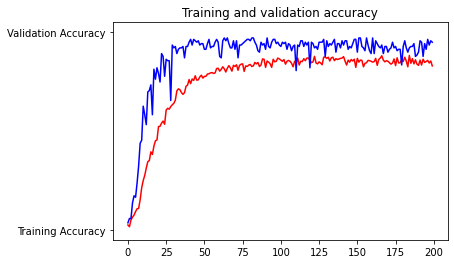

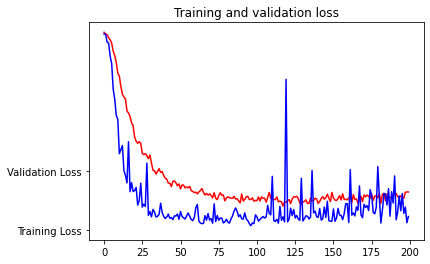

In [81]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


# Desired output. Charts with training and validation metrics. No crash :)

In [82]:
#evaluate the model with test data

#get the labels
x_test,y_test=testing_generator.next()
eval_result = model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 0s 201ms/step - loss: 0.0049 - acc: 1.0000
[test loss, test accuracy]: [0.004884188529103994, 1.0]


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
# Save the entire model as a SavedModel.



!mkdir -p "/content/savemodel"
model.save('/content/saved_model/my_model2') 
!zip -r '/content/saved_model/file2.zip' '/content/saved_model/my_model2'
from google.colab import files
#files.download("/content/saved_model/file.zip")

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print("---------------Found classes ----------------")
  print( classes[0])
  print( classes[0][0])
  for i in range (len(classes[0])):
    if (1-classes[0][i])<0.1:
      print(s[i])

INFO:tensorflow:Assets written to: /content/saved_model/my_model2/assets
  adding: content/saved_model/my_model2/ (stored 0%)
  adding: content/saved_model/my_model2/keras_metadata.pb (deflated 92%)
  adding: content/saved_model/my_model2/saved_model.pb (deflated 89%)
  adding: content/saved_model/my_model2/assets/ (stored 0%)
  adding: content/saved_model/my_model2/variables/ (stored 0%)
  adding: content/saved_model/my_model2/variables/variables.index (deflated 66%)
  adding: content/saved_model/my_model2/variables/variables.data-00000-of-00001 (deflated 33%)
